Hueristic: while model selection and hyperparameter tuning is essential for validating performance, getting more data or producing more meaningful features is often necessary to achieve major performance improvments.

Wikipedia on Feature Engineering: "Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Feature engineering is fundamental to the application of machine learning, and is both difficult and expensive."

Examples of feature engineering:
* Heating/cooling degrees at various balance points
* Weather indecies (e.g. https://www.weather.gov/ama/heatindex)
* Trailing squences of hourly weather data
* adding tags associated with day of week, time of day, holidays, etc

# How well can we predict the monthly energy usage of NYC?

The test will see if we can use data from 2016 and 2018 to predict the usage from 2017. 

using only:
* [Custom NYISO load export of NYC](https://www.nyiso.com/custom-reports?report=int_rt_actual_load)
* [Hourly weather of central park](https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:94728/detail)
* and of course pandas/sklearn/seaborn/juptyer/python

![title](images\\central_park.png)

# Let's start by loading in the time series data


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data_path = "../data/nyc/"
load_files = ["nyc-load-2016.csv", "nyc-load-2017.csv", "nyc-load-2018.csv"]
load_dataframes = []

for load_file in load_files:
    df_in = pd.read_csv(data_path + load_file)
    load_dataframes.append(df_in)
    
load_raw = pd.concat(load_dataframes)

weather_files = ["nyc-weather-2016.csv", "nyc-weather-2017.csv", "nyc-weather-2018.csv"]
weather_dataframes = []
weather_columns = ["DATE", "HourlyDewPointTemperature",
                   "HourlyDryBulbTemperature",
                  "HourlyRelativeHumidity"]

for weather_file in weather_files:
    df_in = pd.read_csv(data_path + weather_file, low_memory=False)
    weather_dataframes.append(df_in[weather_columns])
    
weather_raw = pd.concat(weather_dataframes)

In [2]:
load_raw.head()

Eastern Date Hour Zone Name  Zone PTID  TWI Actual Load
0  2016/01/01 00:00:00    N.Y.C.      61761           4894.5
1  2016/01/01 01:00:00    N.Y.C.      61761           4712.7
2  2016/01/01 02:00:00    N.Y.C.      61761           4510.4
3  2016/01/01 03:00:00    N.Y.C.      61761           4368.4
4  2016/01/01 04:00:00    N.Y.C.      61761           4286.8

In [3]:
load_raw.tail()

Eastern Date Hour Zone Name  Zone PTID  TWI Actual Load
8755  12/31/2018 19:00    N.Y.C.      61761           5987.3
8756  12/31/2018 20:00    N.Y.C.      61761           5781.7
8757  12/31/2018 21:00    N.Y.C.      61761           5568.7
8758  12/31/2018 22:00    N.Y.C.      61761           5330.7
8759  12/31/2018 23:00    N.Y.C.      61761           5103.1

In [4]:
weather_raw.head()

DATE HourlyDewPointTemperature HourlyDryBulbTemperature  \
0  2016-01-01T00:51:00                        25                       42   
1  2016-01-01T01:51:00                        25                       41   
2  2016-01-01T02:51:00                        26                       41   
3  2016-01-01T03:51:00                        26                       41   
4  2016-01-01T04:51:00                        26                       40   

  HourlyRelativeHumidity  
0                     51  
1                     53  
2                     55  
3                     55  
4                     58

In [5]:
weather_raw.tail()

DATE HourlyDewPointTemperature HourlyDryBulbTemperature  \
12385  2018-12-31T17:58:00                        41                       43   
12386  2018-12-31T18:24:00                        41                       44   
12387  2018-12-31T18:33:00                        42                       44   
12388  2018-12-31T18:46:00                        43                       45   
12389  2018-12-31T18:51:00                        42                       44   

      HourlyRelativeHumidity  
12385                     93  
12386                     89  
12387                     93  
12388                     93  
12389                     93

# Wrangle dataframes and convert timestamps

we are going to train and validate the models on calendar year 2016 and 2018 and then test performance on 2017.

In [6]:
load_index = pd.DatetimeIndex(load_raw['Eastern Date Hour']).tz_localize('US/Eastern', ambiguous='infer')

load = pd.Series(load_raw['TWI Actual Load'].values,
                 index = load_index,
                 name='load [MWh]').dropna()

ax = plt.gca()
ax.axvspan(pd.to_datetime('2017'), pd.to_datetime('2018'), alpha=0.5, color='red')

load.plot(figsize=(12,4))
plt.show()

C:\Users\James.Kennedy\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [7]:
weather_X = weather_raw.drop('DATE', axis=1)
weather_X_numeric = weather_X.apply(lambda x: pd.to_numeric(x, errors='coerce'))
weather_index = pd.DatetimeIndex(weather_raw.DATE).tz_localize('EST').tz_convert('US/Eastern')


weather = pd.DataFrame(weather_X_numeric.values,
                       index = weather_index,
                       columns=weather_X.columns)

weather = weather.resample('1h').mean().dropna()

weather.plot(subplots=True, figsize=(12,12))
plt.show()

In [8]:
shared_index = weather.index.intersection(load.index).dropna()

dfs = [load.loc[shared_index], weather.loc[shared_index, :]]
df = pd.concat(dfs, axis=1)
df.head()

load [MWh]  HourlyDewPointTemperature  \
2016-01-01 00:00:00-05:00      4894.5                       25.0   
2016-01-01 01:00:00-05:00      4712.7                       25.0   
2016-01-01 02:00:00-05:00      4510.4                       26.0   
2016-01-01 03:00:00-05:00      4368.4                       26.0   
2016-01-01 04:00:00-05:00      4286.8                       26.0   

                           HourlyDryBulbTemperature  HourlyRelativeHumidity  
2016-01-01 00:00:00-05:00                      42.0                    51.0  
2016-01-01 01:00:00-05:00                      41.0                    53.0  
2016-01-01 02:00:00-05:00                      41.0                    55.0  
2016-01-01 03:00:00-05:00                      41.0                    55.0  
2016-01-01 04:00:00-05:00                      40.0                    58.0

# let's explore the relationship between load and weather a bit 

In [9]:
plt.scatter(df.HourlyDewPointTemperature, df['load [MWh]'],
            alpha=.01)

plt.xlabel('dew point temperature')
plt.ylabel('Load, MW')
plt.show()

In [10]:
plt.scatter(df.HourlyDryBulbTemperature, df['load [MWh]'],
            alpha=.01)

plt.xlabel('dry bulb temperature')
plt.ylabel('Load, MWh')
plt.show()

### day of week (i.e. dow) starts with Monday as 0 and ends with Sunday as 6

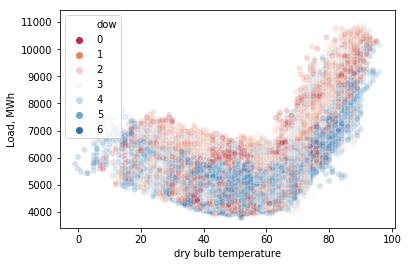

In [11]:
df_weekday = df.copy()
df_weekday['dow'] = df.index.dayofweek

sns.scatterplot(x='HourlyDryBulbTemperature',
                y='load [MWh]',
                hue='dow', palette=sns.color_palette("RdBu", n_colors=7),
                data=df_weekday, alpha=.2)

plt.xlabel('dry bulb temperature')
plt.ylabel('Load, MWh')
plt.show()

# The target will be predicting total monthly usage in 2017

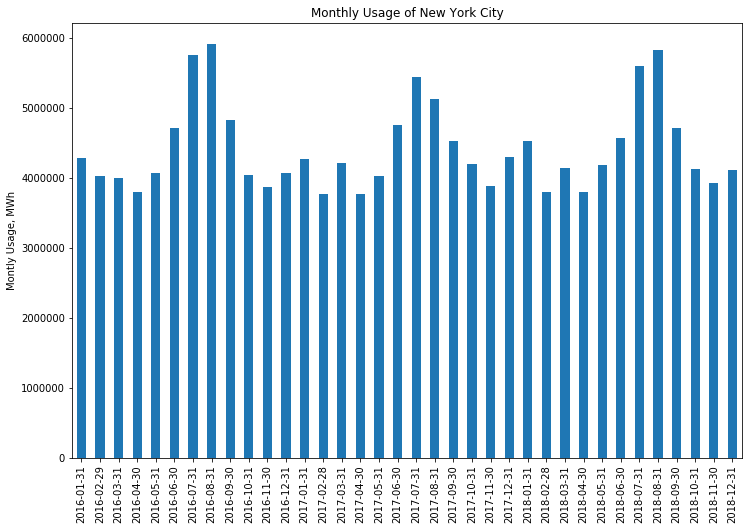

In [12]:
monthly_load = df['load [MWh]'].resample('1M').sum()

monthly_load.index = monthly_load.index.date

monthly_load.plot.bar(figsize=(12,8))
plt.title('Monthly Usage of New York City')
plt.ylabel('Montly Usage, MWh')
plt.show()

# define the index values for the testing set and the train/validation set

all the models will be trained on data from 2016 and 2018 and then tested on data from 2017.

In [13]:
hourly_test_index = df.index[df.index.year==2017]
hourly_train_val_index = df.index[df.index.year!=2017]

monthly_test_index = monthly_load.index[monthly_load.index.map(lambda x: x.year)==2017]
monthly_train_val_index = monthly_load.index[monthly_load.index.map(lambda x: x.year)!=2017]

# let's "engineer" some hourly heating/cooling degree hours and then roll those up to monthly basis as well.

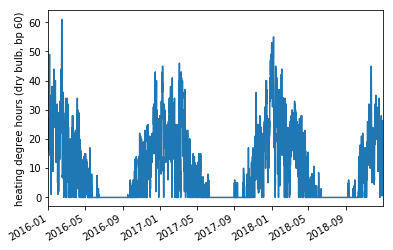

In [14]:
# some functions for calculating degree hours

def get_cooling_degree_hours(temp_series, cooling_balance_point):
    """return series of cooling degree hours"""
    cooling_degree_hours = temp_series - cooling_balance_point
    cooling_degree_hours[cooling_degree_hours<0] = 0
    return cooling_degree_hours

def get_heating_degree_hours(temp_series, heating_balance_point):
    """return series of cooling degree hours"""
    heating_degree_hours = heating_balance_point - temp_series 
    heating_degree_hours[heating_degree_hours<0] = 0
    return heating_degree_hours

# an example
get_heating_degree_hours(df.HourlyDryBulbTemperature, 60).plot()
plt.ylabel('heating degree hours (dry bulb, bp 60)')
plt.show()

In [15]:
degree_hours = {}

balance_points = [50, 55, 60, 65, 75]

for bp in balance_points:
    
    # heating, dry bulb
    degree_hours['hdh_db_'+str(bp)] = get_heating_degree_hours(df.HourlyDryBulbTemperature, bp)
    
    # heating, dew point
    degree_hours['hdh_dp_'+str(bp)] = get_heating_degree_hours(df.HourlyDewPointTemperature, bp)
    
    # cooling, dry bulb
    degree_hours['cdh_db_'+str(bp)] = get_cooling_degree_hours(df.HourlyDryBulbTemperature, bp)
    
    # cooling, dew point
    degree_hours['cdh_dp_'+str(bp)] = get_cooling_degree_hours(df.HourlyDewPointTemperature, bp)
    
degree_hours = pd.DataFrame(degree_hours) 
degree_hours.head()

hdh_db_50  hdh_dp_50  cdh_db_50  cdh_dp_50  \
2016-01-01 00:00:00-05:00        8.0       25.0        0.0        0.0   
2016-01-01 01:00:00-05:00        9.0       25.0        0.0        0.0   
2016-01-01 02:00:00-05:00        9.0       24.0        0.0        0.0   
2016-01-01 03:00:00-05:00        9.0       24.0        0.0        0.0   
2016-01-01 04:00:00-05:00       10.0       24.0        0.0        0.0   

                           hdh_db_55  hdh_dp_55  cdh_db_55  cdh_dp_55  \
2016-01-01 00:00:00-05:00       13.0       30.0        0.0        0.0   
2016-01-01 01:00:00-05:00       14.0       30.0        0.0        0.0   
2016-01-01 02:00:00-05:00       14.0       29.0        0.0        0.0   
2016-01-01 03:00:00-05:00       14.0       29.0        0.0        0.0   
2016-01-01 04:00:00-05:00       15.0       29.0        0.0        0.0   

                           hdh_db_60  hdh_dp_60  cdh_db_60  cdh_dp_60  \
2016-01-01 00:00:00-05:00       18.0       35.0        0.0        0.0   
2016-01-01 01:00:00-05:00       19.0       35.0        0.0        0.0   
2016-01-01 02:00:00-05:00       19.0       34.0        0.0        0.0   
2016-01-01 03:00:00-05:00       19.0       34.0        0.0        0.0   
2016-01-01 04:00:00-05:00       20.0       34.0        0.0        0.0   

                           hdh_db_65  hdh_dp_65  cdh_db_65  cdh_dp_65  \
2016-01-01 00:00:00-05:00       23.0       40.0        0.0        0.0   
2016-01-01 01:00:00-05:00       24.0       40.0        0.0        0.0   
2016-01-01 02:00:00-05:00       24.0       39.0        0.0        0.0   
2016-01-01 03:00:00-05:00       24.0       39.0        0.0        0.0   
2016-01-01 04:00:00-05:00       25.0       39.0        0.0        0.0   

                           hdh_db_75  hdh_dp_75  cdh_db_75  cdh_dp_75  
2016-01-01 00:00:00-05:00       33.0       50.0        0.0        0.0  
2016-01-01 01:00:00-05:00       34.0       50.0        0.0        0.0  
2016-01-01 02:00:00-05:00       34.0       49.0        0.0        0.0  
2016-01-01 03:00:00-05:00       34.0       49.0        0.0        0.0  
2016-01-01 04:00:00-05:00       35.0       49.0        0.0        0.0

# so we went from (2) temperature features to (20) degree hour features

cooling vs heating at (5) different balance points: factor of (10)

now let's wrap these features to total values for each month

In [16]:
degree_hour_months = degree_hours.resample('1M').sum()
degree_hour_months.index = degree_hour_months.index.date

degree_hour_months.head()

hdh_db_50     hdh_dp_50    cdh_db_50    cdh_dp_50  \
2016-01-31  11524.316667  24111.783333    97.250000    33.833333   
2016-02-29   9181.533333  19919.467857   601.308333   110.450000   
2016-03-31   3827.673810  15496.100000  2492.800000    63.033333   
2016-04-30   2192.250000  13360.583333  4030.976190   327.428571   
2016-05-31    189.066667   4654.183333  9019.550000  1859.750000   

               hdh_db_55     hdh_dp_55    cdh_db_55    cdh_dp_55  \
2016-01-31  15157.316667  27788.950000    20.250000     1.000000   
2016-02-29  12196.408333  23285.717857   141.183333     1.700000   
2016-03-31   6396.507143  19151.266667  1346.633333     3.200000   
2016-04-30   4049.583333  16706.750000  2293.309524    78.595238   
2016-05-31    984.533333   7454.783333  6155.016667  1000.350000   

               hdh_db_60     hdh_dp_60    cdh_db_60   cdh_dp_60     hdh_db_65  \
2016-01-31  18847.066667  31497.950000     0.000000    0.000000  22557.066667   
2016-02-29  15532.225000  26759.017857     2.000000    0.000000  19005.225000   
2016-03-31   9461.673810  22863.066667   696.800000    0.000000  12786.673810   
2016-04-30   6565.583333  20223.583333  1214.309524    0.428571   9443.107143   
2016-05-31   2488.533333  10525.283333  3999.016667  410.850000   4591.033333   

               hdh_dp_65    cdh_db_65  cdh_dp_65     hdh_db_75     hdh_dp_75  \
2016-01-31  35207.950000     0.000000       0.00  29977.066667  42627.950000   
2016-02-29  30234.017857     0.000000       0.00  25955.225000  37184.017857   
2016-03-31  26578.066667   306.800000       0.00  19919.873810  34008.066667   
2016-04-30  23818.154762   496.833333       0.00  16178.273810  31008.154762   
2016-05-31  13841.283333  2441.516667      66.85  10048.016667  21094.433333   

            cdh_db_75  cdh_dp_75  
2016-01-31        0.0        0.0  
2016-02-29        0.0        0.0  
2016-03-31       10.0        0.0  
2016-04-30       42.0        0.0  
2016-05-31      578.5        0.0

# let's do some monthly level linear modeling

* We'll use Lasso linear model https://en.wikipedia.org/wiki/Lasso_(statistics) 
    * so we can force the coefficients to be positive
    * and because feature selection comes standard with Lasso
        * https://scikit-learn.org/stable/modules/feature_selection.html#l1-based-feature-selection
    * and finally we can use the CV version in which cross validation comes standard!!
        * https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV

In [17]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

X = degree_hour_months.loc[monthly_train_val_index]
y = monthly_load.loc[monthly_train_val_index]

# cross validation baked in!!!
linear_lasso = LassoCV(cv=5, positive=True, random_state=42, max_iter=10000)
linear_lasso.fit(X, y)

linear_coefficients = linear_lasso.coef_
non_zero_linear_coefficients = linear_coefficients[linear_coefficients!=0]
lasso_selected_features = X.columns[linear_coefficients!=0]

pd.Series(non_zero_linear_coefficients,
          index=lasso_selected_features,
          name='coeffiecients')

cdh_db_50     13.993815
cdh_dp_50     61.360501
cdh_db_60    105.184227
hdh_db_65     40.059125
cdh_db_65     36.683582
hdh_dp_75     11.503685
Name: coeffiecients, dtype: float64

### the Lasso model selected the best 6 features using cross validation

### now let's see how it predits the months from 2017

7199.8815065060035
0.971514704660547


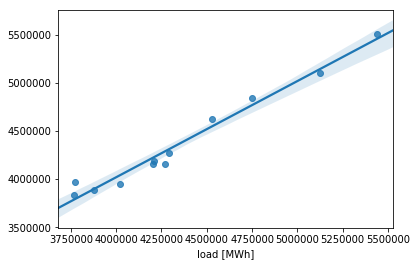

In [18]:
from sklearn.metrics import mean_squared_error, r2_score


X_test = degree_hour_months.loc[monthly_test_index]
y_test = monthly_load.loc[monthly_test_index]

y_pred_linear = linear_lasso.predict(X_test)

linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)

print(linear_mse/1e6)
print(linear_r2)

sns.regplot(x=y_test, y=y_pred_linear)
plt.show()

# not bad! now let's do the random forest on the hourly data

In [19]:
from sklearn.ensemble import RandomForestRegressor

X_hourly = degree_hours.loc[hourly_train_val_index]
y_hourly = df['load [MWh]'].loc[hourly_train_val_index]

forest = RandomForestRegressor(random_state=42,
                               n_estimators=300,
                               max_features=.8,
                               min_samples_leaf=10)
forest.fit(X_hourly, y_hourly)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.8, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

609518.0004886499
0.5701204113127533


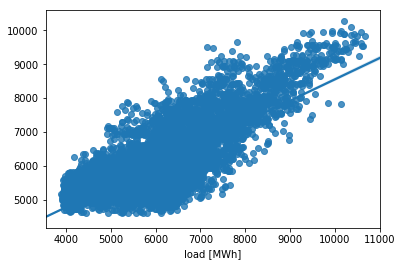

In [20]:
X_test_hourly = degree_hours.loc[hourly_test_index]
y_test_hourly = df['load [MWh]'].loc[hourly_test_index]

y_pred_forest_hourly = forest.predict(X_test_hourly)

forest_hourly_mse = mean_squared_error(y_test_hourly, y_pred_forest_hourly)
forest_hourly_r2 = r2_score(y_test_hourly, y_pred_forest_hourly)

print(forest_hourly_mse)
print(forest_hourly_r2)

sns.regplot(x=y_test_hourly, y=y_pred_forest_hourly)
plt.show()

### but in order for the comparison to be far, let's resample these hourly predictions up to the montly level

In [21]:
y_pred_forest_hourly_srs = pd.Series(y_pred_forest_hourly,
                                     index=hourly_test_index)

y_pred_forest_monthly = y_pred_forest_hourly_srs.resample('1M').sum()

forest_mse = mean_squared_error(y_test, y_pred_forest_monthly)
forest_r2 = r2_score(y_test, y_pred_forest_monthly)

print(forest_mse/1e6)
print(forest_r2)

sns.regplot(x=y_test, y=y_pred_forest_monthly)
plt.show()

12652.62564126354
0.9499417069731984


# so the hourly forest out of the box isn't as good for monthly prediction...

## but let's try to get introduce more data to see if it will improve

In [22]:
def expand_features(X):
    """return the feature dataframe with expanded features:
    * the mean daily value for each degree-hour feature
    * the day of the week
    * the hour in the day
    """
    X_more = X.copy()
    
    for col in X_more:
        X_more[col+'daily_mean'] = X_more[col].resample('1d').mean().resample('1h').ffill()
        
    X_more = X_more.fillna(method='ffill')
    
    X_more['dow'] = X_more.index.dayofweek # day of week
    X_more['hour'] = X_more.index.hour # hour of day
    
    return X_more

X_expanded = expand_features(X_hourly)

In [23]:
%%time

forest.fit(X_expanded, y_hourly)

X_test_hourly = expand_features(degree_hours.loc[hourly_test_index])
y_test_hourly = df['load [MWh]'].loc[hourly_test_index]

y_pred_forest_hourly = forest.predict(X_test_hourly)

forest_hourly_mse = mean_squared_error(y_test_hourly, y_pred_forest_hourly)
forest_hourly_r2 = r2_score(y_test_hourly, y_pred_forest_hourly)

print(forest_hourly_mse)
print(forest_hourly_r2)

sns.regplot(x=y_test_hourly, y=y_pred_forest_hourly)
plt.show()

86818.13019880619
0.9387690895584082


Wall time: 45.5 s


In [24]:
y_pred_forest_hourly_srs = pd.Series(y_pred_forest_hourly,
                                     index=hourly_test_index)

y_pred_forest_monthly = y_pred_forest_hourly_srs.resample('1M').sum()

forest_mse = mean_squared_error(y_test, y_pred_forest_monthly)
forest_r2 = r2_score(y_test, y_pred_forest_monthly)

print(forest_mse/1e6)
print(forest_r2)

sns.regplot(x=y_test, y=y_pred_forest_monthly)
plt.show()

4803.602678036371
0.9809952370947205


# looks like we beat the linear model on the monthly test!

let's take a look to see how the hourly prediction looks as a time series and which features were most important for the random forest model

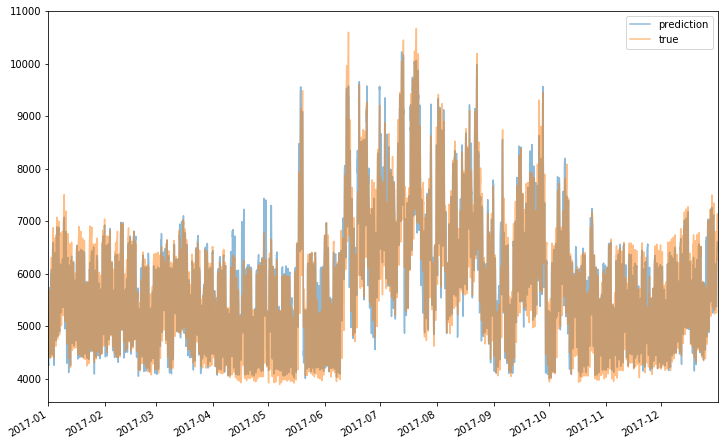

In [25]:
final_df = pd.DataFrame({'prediction': y_pred_forest_hourly,
                         'true': y_test_hourly},
                        index = y_test_hourly.index)

final_df.plot(figsize=(12,8), alpha=.5)
plt.show()

In [26]:
feature_importances = pd.Series(forest.feature_importances_,
                                   index=X_expanded.columns)

feature_importances.sort_values().plot.barh(figsize=(12, 8))
plt.title("importance of the features for prediction")
plt.show()